### Preprocessing

In [1]:
# load pandas library
import pandas as pd

# read csv
data = pd.read_csv('data.csv')
# observe first five instances of data
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [2]:
# observe an example review to see if textual preprocessing is needed
example_review = data.iloc[1, 0]
example_review

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [3]:
# load bs4 to access BeautifulSoup, which has a html parser
from bs4 import BeautifulSoup
# load re for substitute function
import re

def parse_review(text):
    # functiion for parsing html string
    soup = BeautifulSoup(text, 'html.parser')
    parsed_text = soup.get_text()
    return str(parsed_text)

def clean_text(text):
    # function for cleaning text

    # parse text
    parsed_text = parse_review(text)

    # substitute symbology with an empty string
    cleaned_text = re.sub("\[[^]]*\]'-", '', parsed_text)

    # lowercase all text
    cleaned_text = cleaned_text.lower()
    return cleaned_text


In [4]:
# apply cleaning to the review column in data

data['review'] = data['review'].apply(clean_text)

/home/whan/Desktop/fellowship.ai/.env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [5]:
# import sklearn module for splitting data into 70:15:15 proportions and binarizing labels
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

# X is our input and y is our target
X = data['review'].values
y = data['sentiment'].values

# binarize labels
binarized_labels = label_binarize(y, classes = ['negative', 'positive'])

# reshape binarized labels array into a 1 dimensional array
binarized_labels = binarized_labels.squeeze(1)


# Split data into train validation and test sets
X_train, X_test, y_train, y_test = train_test_split(X, binarized_labels, shuffle = True, test_size=0.3, random_state=2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle = True, test_size = 0.5, random_state = 2)

In [6]:
# see how many positive and negative labels
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

### Training

In [7]:
# Configurations
from transformers import BertTokenizer, BertForSequenceClassification
import gc
import torch

max_length = 50
batch_size = 16
epochs = 10
number_of_classes = 2
learning_rate = 1e-4
weight_decay = 1e-4

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
pretrained_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = number_of_classes)


# garbage collect and empty cuda cache
gc.collect()
torch.cuda.empty_cache()

# set device to gpu or cpu, whichever is available
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


/home/whan/Desktop/fellowship.ai/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassif

In [8]:
# import modules to create PyTorch Dataset and PyTorch DataLoader
from torch.utils.data import DataLoader, Dataset

# Create PyTorch Dataset class
class TextSentimentDataset(Dataset):
    def __init__(self, reviews, sentiments, tokenizer, max_length, device):
        self.reviews = reviews
        self.sentiments = sentiments
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device
        
    def __len__(self):
        return len(self.sentiments)
    
    def __getitem__(self, idx):
        review = self.reviews[idx]
        sentiment = self.sentiments[idx]
        
        # Tokenize reviews and retrieve input_ids for model
        inputs = self.tokenizer(review, 
                                max_length = self.max_length,
                                add_special_tokens = True,
                                return_attention_mask = True, 
                                padding = 'max_length', 
                                truncation = True, 
                                return_tensors = 'pt').to(self.device)
        input_ids = inputs.input_ids
        attention_mask = inputs.attention_mask
        sentiment = torch.tensor(sentiment, dtype=torch.long)
        
        return input_ids, attention_mask, sentiment
    

def create_dataloader(X, y, batch_size, tokenizer, max_length, device):
    # function for creating PyTorch DataLoader

    pytorch_dataset = TextSentimentDataset(
        reviews = X,
        sentiments = y,
        tokenizer = tokenizer,
        max_length = max_length,
        device = device
    )

    pytorch_dataloader = DataLoader(
        dataset = pytorch_dataset,
        batch_size = batch_size,
        shuffle = True
    )

    return pytorch_dataloader, pytorch_dataset
        


In [9]:
# create dataloaders for train, validation, test sets

train_loader, train_dataset = create_dataloader(X_train, y_train, batch_size, tokenizer, max_length, device)
val_loader, val_dataset = create_dataloader(X_val, y_val, batch_size, tokenizer, max_length, device)
test_loader, test_dataset = create_dataloader(X_test, y_test, batch_size, tokenizer, max_length, device)

In [10]:
# import torch modules for creating model and loss criterion
from torch import nn
import torch.nn.functional as F


def calculate_loss(pred, label):
    #function for calculating loss and returning number of correct predictions
    loss = F.cross_entropy(pred, label, reduction = 'sum')
    pred = pred.max(1)[1]
    number_correct = pred.eq(label).sum().item()

    return loss, number_correct

class SentimentAnalysis(nn.Module):
    # Pytorch class for creating models
    def __init__(self, number_of_classes, pretrained_model):
        super(SentimentAnalysis, self).__init__()
        self.pretrained_model = pretrained_model
        # Softmax activation function to get probabilities 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids, attention_mask, labels):
        out = self.pretrained_model(
            input_ids = input_ids,
            attention_mask = attention_mask,
            labels = labels
        )
        logits = out.logits
        preds = self.softmax(logits)
        loss = out.loss
        return logits, loss

In [11]:
# import numpy module
import numpy as np

class EarlyStopper:
    # stops the training process if the model does not improve validation loss
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False



In [12]:
# instantiate model
model = SentimentAnalysis(
    number_of_classes = number_of_classes,
    pretrained_model = pretrained_model
).to(device)

# instantiate Adam optimizer
optimizer = torch.optim.AdamW(params = model.parameters(), lr = learning_rate, weight_decay=weight_decay)

#instantiate early stopping policy
early_stopping = EarlyStopper(patience=3, min_delta=0.2)

In [13]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
gc.collect()
torch.cuda.empty_cache()

def calculate_statistic(cm, class_num):
    # function for calculating precision, recall, and f1 score from confusion matrix
    total_pred = cm.sum(0)
    total_true = cm.sum(1)

    pre_i = [cm[i, i] / total_pred[i] for i in range(class_num)]
    rec_i = [cm[i, i] / total_true[i] for i in range(class_num)]
    F1_i = [2 * pre_i[i] * rec_i[i] / (pre_i[i] + rec_i[i]) for i in range(class_num)]

    pre_i = np.array(pre_i)
    rec_i = np.array(rec_i)
    F1_i = np.array(F1_i)
    pre_i[np.isnan(pre_i)] = 0
    rec_i[np.isnan(rec_i)] = 0
    F1_i[np.isnan(F1_i)] = 0

    return sum(list(pre_i))/len(list(pre_i)), sum(list(rec_i))/len(list(rec_i)), sum(list(F1_i))/len(list(F1_i))


# functions for training, evaluating, and testing

def train(train_loader, device, model, optimizer, total_num):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc='- (Training)  '): 

        input_ids, attention_mask, label = map(lambda x: x.to(device), batch)
        optimizer.zero_grad()
        input_ids = input_ids.squeeze(1)
        attention_mask = attention_mask.squeeze(1)
        pred, loss = model(input_ids, attention_mask, labels = label)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    train_loss = total_loss / total_num
    return train_loss


def validate(val_loader, device, model, total_num):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='- (Validating)  '): 

            input_ids, attention_mask, label = map(lambda x: x.to(device), batch)
            input_ids = input_ids.squeeze(1)
            pred, loss = model(input_ids, attention_mask, labels = label)

            total_loss += loss.item()

    val_loss = total_loss / total_num
    return val_loss


def test(test_loader, device, model, total_num):
    all_labels = []
    all_res = []
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc='- (Testing)  '): 
            
            input_ids, attention_mask, label = map(lambda x: x.to(device), batch)
            input_ids = input_ids.squeeze(1)
            pred, loss = model(input_ids, attention_mask, labels = label)
            all_labels.extend(label.cpu().numpy())
            all_res.extend(pred.max(1)[1].cpu().numpy())

            total_loss += loss.item()

    test_loss = total_loss / total_num

    print(f'Test Loss: {test_loss}')
    
    # create confusion matrix from labels and predictions
    cm = confusion_matrix(all_labels, all_res)
    print(f'Test confusion matrix: {cm}')
    Precision, Recall, F1 = calculate_statistic(cm, number_of_classes)
    print(f'Test Precision: {Precision}')
    print(f'Test Recall: {Recall}')
    print(f'Test F1: {F1}')

[ Epoch 0 ]


- (Training)  : 100%|██████████| 2188/2188 [05:42<00:00,  6.40it/s]


Train Loss: 0.5152606469812298


- (Validating)  : 100%|██████████| 469/469 [00:41<00:00, 11.43it/s]


Val Loss: 0.6983104550253862
    - [Info] The checkpoint file has been updated.
[ Epoch 1 ]


- (Training)  : 100%|██████████| 2188/2188 [05:56<00:00,  6.15it/s]


Train Loss: 0.6955665144286164


- (Validating)  : 100%|██████████| 469/469 [00:42<00:00, 10.93it/s]


Val Loss: 0.6937076715009807
    - [Info] The checkpoint file has been updated.
[ Epoch 2 ]


- (Training)  : 100%|██████████| 2188/2188 [05:56<00:00,  6.15it/s]


Train Loss: 0.6952858976951682


- (Validating)  : 100%|██████████| 469/469 [00:43<00:00, 10.83it/s]


Val Loss: 0.6930877094838157
    - [Info] The checkpoint file has been updated.
[ Epoch 3 ]


- (Training)  : 100%|██████████| 2188/2188 [05:52<00:00,  6.20it/s]


Train Loss: 0.6946235533660683


- (Validating)  : 100%|██████████| 469/469 [00:43<00:00, 10.85it/s]


Val Loss: 0.6933348499127289
[ Epoch 4 ]


- (Training)  : 100%|██████████| 2188/2188 [05:52<00:00,  6.21it/s]


Train Loss: 0.6942073972504144


- (Validating)  : 100%|██████████| 469/469 [00:43<00:00, 10.89it/s]


Val Loss: 0.6935796750379778
[ Epoch 5 ]


- (Training)  : 100%|██████████| 2188/2188 [05:53<00:00,  6.19it/s]


Train Loss: 0.6938505765506947


- (Validating)  : 100%|██████████| 469/469 [00:42<00:00, 10.99it/s]


Val Loss: 0.6962876422827178
[ Epoch 6 ]


- (Training)  : 100%|██████████| 2188/2188 [06:00<00:00,  6.07it/s]


Train Loss: 0.6938960608333294


- (Validating)  : 100%|██████████| 469/469 [00:44<00:00, 10.46it/s]


Val Loss: 0.6933842427186621
[ Epoch 7 ]


- (Training)  : 100%|██████████| 2188/2188 [06:04<00:00,  6.01it/s]


Train Loss: 0.6937335477341682


- (Validating)  : 100%|██████████| 469/469 [00:56<00:00,  8.29it/s]


Val Loss: 0.693773803172081
[ Epoch 8 ]


- (Training)  : 100%|██████████| 2188/2188 [06:28<00:00,  5.63it/s]


Train Loss: 0.6936948104902857


- (Validating)  : 100%|██████████| 469/469 [00:43<00:00, 10.78it/s]


Val Loss: 0.6931772957732683
[ Epoch 9 ]


- (Training)  : 100%|██████████| 2188/2188 [06:03<00:00,  6.02it/s]


Train Loss: 0.6935899880403139


- (Validating)  : 100%|██████████| 469/469 [00:41<00:00, 11.27it/s]


Val Loss: 0.693172032009564
ALL DONE


- (Testing)  : 100%|██████████| 469/469 [00:39<00:00, 11.77it/s]

Test Loss: 0.693344454140043
Test confusion matrix: [[   0 3790]
 [   0 3710]]
Test Precision: 0.24733333333333332
Test Recall: 0.5
Test F1: 0.33095450490633366



/tmp/ipykernel_1545646/1566561630.py:11: RuntimeWarning: invalid value encountered in long_scalars
  pre_i = [cm[i, i] / total_pred[i] for i in range(class_num)]


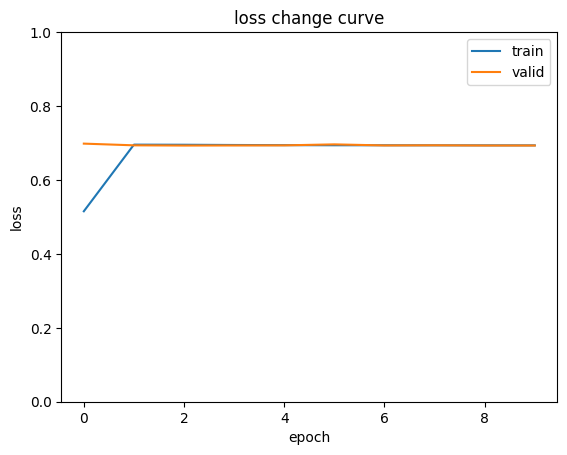

In [14]:
# import module for plotting learning curves
import matplotlib.pyplot as plt

best_epoch = 0
train_accs = []
val_accs = []
val_losses = []
train_losses = []
all_epochs = []

# training and validating loop
for epoch in range(0, epochs):
    print('[ Epoch', epoch, ']')

    train_loss = train(train_loader, device, model, optimizer, len(train_loader))
    print(f'Train Loss: {train_loss}')
    train_losses.append(train_loss)
    val_loss = validate(val_loader, device, model, len(val_loader))
    print(f'Val Loss: {val_loss}')
    val_losses.append(val_loss)

    # save best model checkpoint
    model_state_dict = model.state_dict()

    checkpoint = {
        'model': model_state_dict,
        'config_file': 'config',
        'epoch': epoch}

    if val_loss <= min(val_losses):
        torch.save(checkpoint, 'checkpoint_best.pth')
        print('    - [Info] The checkpoint file has been updated.')

    all_epochs.append(epoch)

    if early_stopping.early_stop(val_loss):
        print("We are at epoch:", epoch)
        break

# plot and save learning curve
print('ALL DONE')               
fig1 = plt.figure('Figure 1')
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label= 'valid')
plt.xlabel('epoch')
plt.ylim([0.0, 1])
plt.ylabel('loss')
plt.legend(loc ="upper right")
plt.title('loss change curve')
plt.savefig(f'checkpoint_best_loss_curve.png')

#load in best model and test
chkpt = torch.load('checkpoint_best.pth', map_location='cuda')
model.load_state_dict(chkpt['model'])
test(test_loader, device, model, len(test_loader))